In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.5 MB/s eta 0:00:00


In [2]:
import gymnasium
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random
from itertools import count
from torch.distributions import Categorical
from sklearn.preprocessing import StandardScaler

In [19]:
class StockEnvironment(gymnasium.Env):
  def __init__(self, folder_path, num_agents = 2, train = True, number_of_days_to_consider = 40, split_ratio = 0.8):
    super(StockEnvironment, self).__init__()

    self.num_agents = num_agents
    self.folder_path = folder_path
    self.train = train
    self.number_of_days_to_consider = number_of_days_to_consider
    self.split_ratio = split_ratio

    self.data = self.load_data(folder_path)
    #print(f"Total Rows: {len(self.data)}")
    #print(f"Total Columns: {len(self.data.columns)}")
    #print("Columns:", self.data.columns.tolist())
    #print("Unique Symbols:", self.data['Symbol'].unique())
    #self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
    #self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

    split_index = int(len(self.data) * self.split_ratio)
    self.training_data = self.data.iloc[:split_index]
    self.testing_data = self.data.iloc[split_index:].reset_index(drop=True)

    self.stock_data = self.training_data if self.train else self.testing_data

    self.action_spaces = {agent_id: spaces.Discrete(3) for agent_id in range(self.num_agents)}
    self.observation_spaces = {agent_id: spaces.Discrete(4) for agent_id in range(self.num_agents)}

    self.agent_states = {agent_id: self.initialize_agent_state() for agent_id in range(self.num_agents)}

    #self.investment_capital = 10000
    #self.number_of_shares = 0
    #self.stock_value = 0
    #self.book_value = 0

    #self.total_account_value = self.investment_capital + self.stock_value
    #self.total_account_value_list = []

    if self.train:
        self.max_timesteps = len(self.training_data) - self.number_of_days_to_consider -1
    else:
        self.max_timesteps = len(self.testing_data) - self.number_of_days_to_consider -1
    self.timestep = 0
    #self.reset()

  def initialize_agent_state(self):
    return {
            "investment_capital": 10000,
            "number_of_shares": 0,
            "stock_value": 0,
            "book_value": 0,
            "total_account_value": 10000,
            "total_account_value_list": [],
        }


  def load_data(self, folder_path):
    combined_data = []
    for filename in os.listdir(folder_path):
      if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        stock_data = pd.read_csv(file_path)
        #stock_data['Symbol'] = filename.replace('_data.csv', '')
        stock_data.columns = ['Date'] + list(stock_data.columns[1:])
        symbol = filename.split('_data.csv')[0]
        stock_data['Symbol'] = symbol
        combined_data.append(stock_data)

    if not combined_data:
          raise ValueError("No data found in the folder.")

    combined_data = pd.concat(combined_data, axis=0)
    #combined_data.sort_values(by=['Symbol', 'Date'], inplace=True)
    combined_data[['open', 'high', 'low', 'close', 'volume']] = StandardScaler().fit_transform(combined_data[['open', 'high', 'low', 'close', 'volume']])
    return combined_data

  def reset(self):

    self.timestep = 0
    self.agent_states = {agent_id: self.initialize_agent_state() for agent_id in range(self.num_agents)}
    #observations = {}
    #for agent_id in range(self.num_agents):
        #observations[agent_id] = self.generate_observation(agent_id)
    observations = {agent_id: self.generate_observation(agent_id) for agent_id in range(self.num_agents)}
    print(f"Reset states: {observations}")
    return observations


  def generate_observation(self, agent_id):

    price_increase_list = []
    stock_data = self.stock_data


    #for i in range(self.number_of_days_to_consider):
     # current_price = stock_data['close'].iloc[self.timestep + i]
    #  next_price = stock_data['close'].iloc[self.timestep + 1 + i]
    #  if next_price - current_price > 0:
    #      price_increase_list.append(1)
    #  else:
    #      price_increase_list.append(0)



    for i in range(self.number_of_days_to_consider):
        current_price = stock_data['close'].iloc[self.timestep + i]
        next_price = stock_data['close'].iloc[self.timestep + 1 + i]
        if next_price - current_price > 0:
            price_increase_list.append(1)
        else:
            price_increase_list.append(0)


    price_increase = (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5
    stock_held = self.agent_states[agent_id]['number_of_shares'] > 0

    if price_increase and not stock_held:
        observation = 0
    elif price_increase and stock_held:
        observation = 1
    elif not price_increase and not stock_held:
        observation = 2
    else:
        observation = 3 #not price_increase and stock_held
    return observation


  def step(self,actions):
    #print(f"Current timestep: {self.timestep}")
    rewards = {}
    observations = {}
    for agent_id, action in actions.items():
      reward = self.environment_action(agent_id, action)
      rewards[agent_id] = reward
      observations[agent_id] = self.generate_observation(agent_id)
      reward = self.environment_action(agent_id, action)
      self.agent_states[agent_id]['total_account_value'] = self.agent_states[agent_id]['investment_capital'] + self.agent_states[agent_id]['stock_value']
      self.agent_states[agent_id]['total_account_value_list'].append(self.agent_states[agent_id]['total_account_value'])
      rewards[agent_id] = reward
      observations[agent_id] = self.generate_observation(agent_id)


    #print(f"Rewards calculated: {rewards}")
    self.timestep += 1
    terminated = self.timestep >= self.max_timesteps

    #for agent_id in actions.keys():
        #observations[agent_id] = self.generate_observation(agent_id)

    truncated = False
    info = {}

    return observations, rewards, terminated, truncated, info

  def render(self, mode='human'):
    """This method renders the agents' total account values over time.

    :param mode: 'human' renders to the current display or terminal and returns nothing."""
    plt.figure(figsize=(15, 10))
    for agent_id, state in self.agent_states.items():
        plt.plot(state['total_account_value_list'], label=f'Agent {agent_id}', linewidth=3)
    plt.xlabel('Days', fontsize=32)
    plt.ylabel('Total Account Value', fontsize=32)
    plt.title('Total Account Value over Time for All Agents', fontsize=38)
    plt.legend(fontsize=18)
    plt.grid(True)
    plt.show()

  def environment_action(self, agent_id, action):
    reward = 0
    agent_state = self.agent_states[agent_id]
    penalty = 0
    transaction_cost = 0
    number_of_shares_to_buy = 0

    current_price_index = self.timestep + self.number_of_days_to_consider
    if current_price_index < len(self.stock_data):
        current_price = self.stock_data['open'].iloc[current_price_index]

        #action logic
        if action == 0:  #buy shares
            if agent_state['number_of_shares'] > 0:
                penalty = -1
            number_of_shares_to_buy = math.floor(agent_state['investment_capital'] / current_price)
            transaction_cost = current_price * number_of_shares_to_buy * 0.005

            if number_of_shares_to_buy > 0:
                agent_state['number_of_shares'] += number_of_shares_to_buy
                agent_state['stock_value'] = agent_state['number_of_shares'] * current_price
                agent_state['investment_capital'] -= number_of_shares_to_buy * current_price
                agent_state['book_value'] += current_price * number_of_shares_to_buy
                reward = number_of_shares_to_buy * 0.1 - transaction_cost
            else:
                reward = -10
        elif action == 1:  #sell shares
            if agent_state['number_of_shares'] > 0:
                sell_value = current_price * agent_state['number_of_shares']
                transaction_cost = sell_value * 0.005
                profit = sell_value - agent_state['book_value'] - transaction_cost
                reward = profit
                agent_state['investment_capital'] += sell_value - transaction_cost
                agent_state['number_of_shares'] = 0
                agent_state['stock_value'] = 0
                agent_state['book_value'] = 0
            else:
               reward = -1

        elif action == 2:  #hold shares
            agent_state['stock_value'] = current_price * agent_state['number_of_shares']
            if agent_state['number_of_shares'] > 0 and agent_state['book_value'] > 0:
                unrealized_profit = agent_state['stock_value'] - agent_state['book_value']
                reward = unrealized_profit / agent_state['book_value']
            else:
                reward = -0.1

        agent_state['stock_value'] = current_price * agent_state['number_of_shares']
        agent_state['total_account_value'] = agent_state['investment_capital'] + agent_state['stock_value']
    else:
        print(f"Index {current_price_index} out of bounds for stock_data with length {len(self.stock_data)}")
        reward = 0

    return reward

In [20]:
env = StockEnvironment('data/', train =True, number_of_days_to_consider= 40)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
class DDQN(nn.Module):
    def __init__(self, observations, actions):
        super(DDQN, self).__init__()
        self.layer1 = nn.Linear(observations, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, actions)

    def forward(self, x):
        #print(f"Input shape: {x.shape}")
        if x.shape != torch.Size([1, 4]):
            raise RuntimeError(f"Incorrect input shape to DQN, expected [1, 4], got {x.shape}")
        x = F.relu(self.layer1(x))
        #print(f"After layer1 shape: {x.shape}")
        x = F.relu(self.layer2(x))
        #print(f"After layer2 shape: {x.shape}")
        x = self.layer3(x)
        #print(f"Output shape: {x.shape}")
        return x

In [23]:
class DDQNAgent:
    def __init__(self, state_size, action_size, lr=0.0001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = DDQN(state_size, action_size).to(device)
        self.target_model = DDQN(state_size, action_size).to(device)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def update_target_model(self):
        """Update target model with policy model's weights."""
        self.target_model.load_state_dict(self.model.state_dict())

    def act(self, state):
        #print(f"State before reshape: {state.shape}")
        state = state.to(device)
        if state.shape != torch.Size([1, 4]):
            raise ValueError(f"Unexpected state shape: {state.shape}")
        act_values = self.model(state)
        #print(f"State act_values: {act_values.shape}")
        return torch.argmax(act_values).item()



    def remember(self, state, action, reward, next_state, done):
        state_tensor = torch.zeros(self.state_size, device=device)
        state_tensor[state] = 1
        next_state_tensor = torch.zeros(self.state_size, device=device)
        next_state_tensor[next_state] = 1
        #print(f"remember: {next_state_tensor.shape}")
        self.memory.append((state_tensor, action, reward, next_state_tensor, done))


    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            if not isinstance(state, torch.Tensor):
                state = torch.FloatTensor(state).to(device)
            if not isinstance(next_state, torch.Tensor):
                next_state = torch.FloatTensor(next_state).to(device)

            state = state.unsqueeze(0)
            next_state = next_state.unsqueeze(0)

            target = reward
            if not done:
                target_q = self.target_model(next_state).max(1)[0].item()
                target = reward + self.gamma * target_q

            current_q = self.model(state)
            #current_q_value = current_q.clone()
            current_q[0][action] = target
            self.optimizer.zero_grad()
            loss = F.mse_loss(current_q, current_q)
            loss.backward()
            self.optimizer.step()

    #def soft_update(self, tau=0.005):
    #    for target_param, local_param in zip(self.target_model.parameters(), self.model.parameters()):
    #        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

Reset states: {0: 0, 1: 0}
Episode 1/50, Agent Rewards: {0: -35.90000000000024, 1: -1773.5044060670534}
Reset states: {0: 0, 1: 0}
Episode 2/50, Agent Rewards: {0: -35.90000000000024, 1: -1773.5044060670534}
Reset states: {0: 0, 1: 0}
Episode 3/50, Agent Rewards: {0: -35.90000000000024, 1: -1773.5044060670534}
Reset states: {0: 0, 1: 0}
Episode 4/50, Agent Rewards: {0: -35.90000000000024, 1: -1773.5044060670534}
Reset states: {0: 0, 1: 0}
Episode 5/50, Agent Rewards: {0: -35.90000000000024, 1: -1773.5044060670534}
Reset states: {0: 0, 1: 0}
Episode 6/50, Agent Rewards: {0: -35.90000000000024, 1: -1773.5044060670534}
Reset states: {0: 0, 1: 0}
Episode 7/50, Agent Rewards: {0: -35.90000000000024, 1: -1773.5044060670534}
Reset states: {0: 0, 1: 0}
Episode 8/50, Agent Rewards: {0: -35.90000000000024, 1: -1773.5044060670534}
Reset states: {0: 0, 1: 0}
Episode 9/50, Agent Rewards: {0: -35.90000000000024, 1: -1773.5044060670534}
Reset states: {0: 0, 1: 0}
Episode 10/50, Agent Rewards: {0: -35

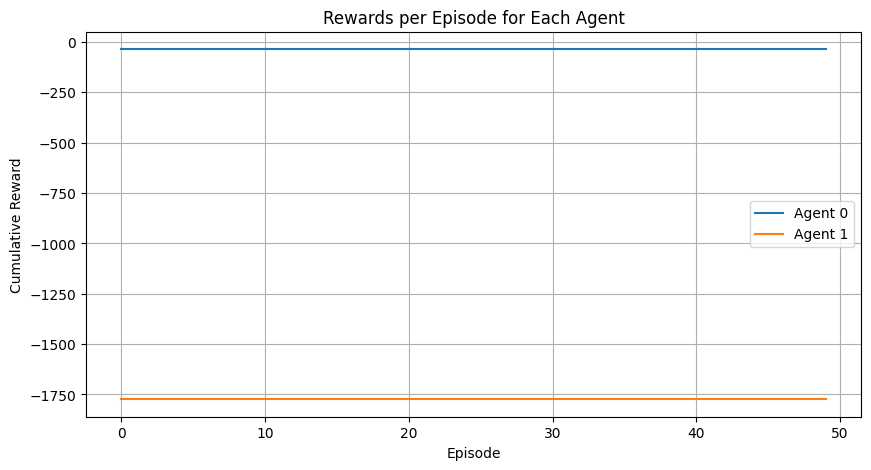

In [24]:
def train_ddqn(env, num_agents, num_episodes):
    agents = {i: DDQNAgent(state_size=4, action_size=3) for i in range(num_agents)}
    target_update_frequency = 10
    rewards_history = {agent_id: [] for agent_id in range(num_agents)}

    for e in range(num_episodes):
        state = env.reset()
        total_rewards = {agent_id: 0 for agent_id in range(num_agents)}

        while True:
            actions = {}
            for agent_id in agents:
                current_state = state[agent_id]
                one_hot_state = torch.zeros(4, device=device)
                one_hot_state[current_state] = 1
                one_hot_state = one_hot_state.unsqueeze(0)

                action = agents[agent_id].act(one_hot_state)
                actions[agent_id] = action

            next_state, rewards, terminated, _, _ = env.step(actions)
            for agent_id in agents:
                #print("State received by agent:", state[agent_id])
                agents[agent_id].remember(state[agent_id], actions[agent_id], rewards[agent_id], next_state[agent_id], terminated)
                if len(agents[agent_id].memory) > 32:
                    agents[agent_id].replay(32)

                total_rewards[agent_id] += rewards[agent_id]

            state = next_state

            if terminated:
                break

        if e % target_update_frequency == 0:
            for agent_id in agents:
                agents[agent_id].update_target_model()

        for agent_id in rewards_history:
            rewards_history[agent_id].append(total_rewards[agent_id])
        print(f"Episode {e+1}/{num_episodes}, Agent Rewards: {total_rewards}")

    #plot
    plt.figure(figsize=(10, 5))
    for agent_id, rewards in rewards_history.items():
        plt.plot(rewards, label=f'Agent {agent_id}')
    plt.title('Rewards per Episode for Each Agent')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

    return agents

env = StockEnvironment('data/', num_agents=2, train=True, number_of_days_to_consider=40)
num_episodes = 50
trained_agents = train_ddqn(env, 2, num_episodes)

In [25]:
def save_model(agent, filename):
    torch.save(agent.model.state_dict(), filename)

for agent_id, agent in trained_agents.items():
    model_filename = f'agent_{agent_id}_final_model.pth'
    save_model(agent, model_filename)


In [29]:
import pickle

save_dir = "model_saves"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

#save the model state
for agent_id, agent in trained_agents.items():
    model_filename = os.path.join(save_dir, f'DDQN_1_agent_{agent_id}_model.pth')
    torch.save(agent.model.state_dict(), model_filename)
    print(f"Model state dictionary for Agent {agent_id} saved to {model_filename}.")

#save the rewards data
rewards_file = os.path.join(save_dir, 'DDQN_1_agent_rewards.pkl')
with open(rewards_file, 'wb') as f:
    pickle.dump(trained_agents, f)
print(f"Rewards data saved to {rewards_file}.")

Model state dictionary for Agent 0 saved to model_saves/DDQN_1_agent_0_model.pth.
Model state dictionary for Agent 1 saved to model_saves/DDQN_1_agent_1_model.pth.
Rewards data saved to model_saves/DDQN_1_agent_rewards.pkl.
